In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [4]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['Random continuous']
sample_concept.prepare_data(env_steps)
test_images = sample_concept.test_images
test_obs = sample_concept.test_obs

In [5]:
#model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)
layer = 5

Loaded model: 20240317-112025-10000000


In [6]:
_, test_acts_dict = model(torch.tensor(test_obs), return_acts=True)
test_acts = test_acts_dict[layer].cpu().detach().numpy()
test_acts = test_acts.reshape(test_acts.shape[0], -1)

In [7]:
class CAV:
    def __init__(self, concept_name):
        self.name = concept_name
        self.concept = concept_instances[concept_name]
        self.probe, self.score = self.concept.load_torch_probe()
        if self.score > 0.5:
            self.coeffs = self.probe[1].weight.data.cpu().numpy().squeeze()
            print(f'{concept_name:^40} | {self.score:^20}')

In [8]:
CAVs = {concept_name.lower(): CAV(concept_name) for concept_name in concept_instances.keys()}

            Player on grass              |        0.971        
             Player on wall              |        0.965        
             Player in air               |        0.937        
             Player dodging              |        0.952        
         Player dodging on wall          |        0.984        
       Bullet aligned with player        |         0.83        
        Good coin left of player         |        0.798        
            Total wall area              |        0.715        
            Visible air wall             |        0.844        
              Visible wall               |        0.895        
             Visible bullet              |        0.919        
              Visible lava               |        0.769        
           Visible blue coin             |        0.824        
           Visible gold coin             |        0.981        
           Visible high coin             |        0.912        
         Visible good low coin          

In [9]:
# Sort images by activation similarity to CAV
def sort(images, acts, cav, best_first=True):
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: cosine_similarity(x[1], cav), reverse=best_first)
    images, acts = zip(*images_acts)
    return images

In [10]:
def plot_images(images, save_name=None):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes = axes.flatten()
    for i in range(3):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.tight_layout()
    if save_name:
        plt.savefig('figures/concept combinations/' + save_name, bbox_inches='tight')
    
    plt.show()

In [11]:
def sort_images(coefficients, best_first, name):
    test_images_sorted = sort(test_images, test_acts, coefficients, best_first)
    plot_images(test_images_sorted, save_name=f'{name}_sorted_{best_first}.png')

In [12]:
def combine_concepts(CAVS, factors, best_first):
    assert len(CAVS) == len(factors) and len(CAVS) > 0
    combined = CAVS[0].coeffs * factors[0]
    combination_str = f'{factors[0]:g}*{CAVS[0].name}'
    for i in range(1, len(CAVS)):
        factor = factors[i]
        if factor >= 0:
            combination_str += f' + {factor:g}*{CAVS[i].name}'
        else:
            combination_str += f' - {-factor:g}*{CAVS[i].name}'
        combined += CAVS[i].coeffs * factor
    print(combination_str)
    sort_images(combined, best_first, name=combination_str)

1*Visible bullet - 1*Player dodging


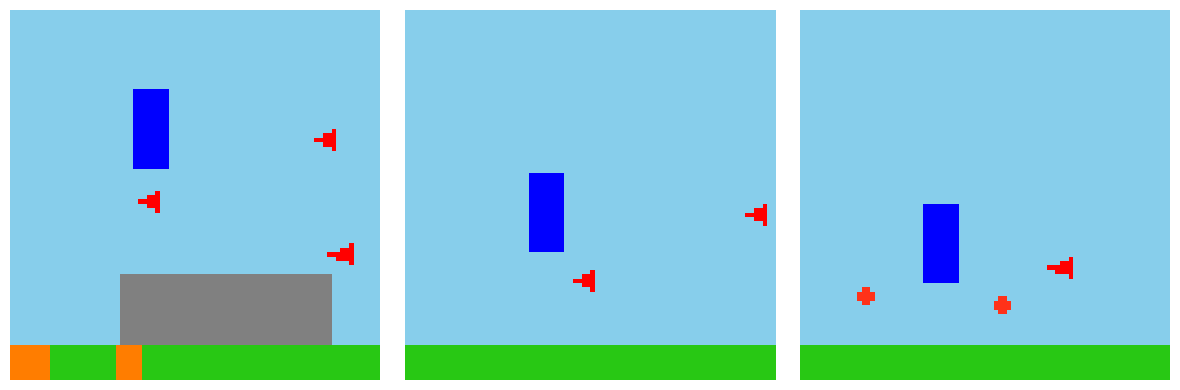

In [54]:
combine_concepts([CAVs['visible bullet'], CAVs['player dodging']], [1, -1], True)

1*Visible bullet - 1*Player dodging + 1*Player on grass


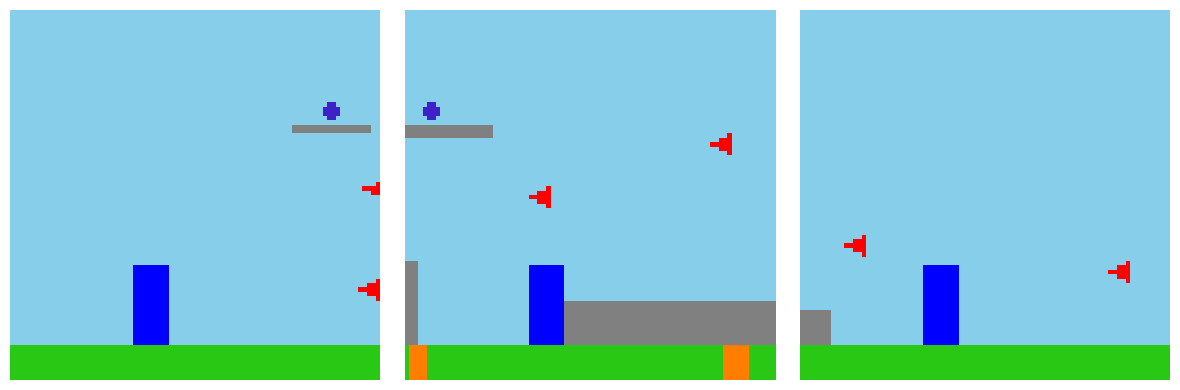

In [55]:
combine_concepts([CAVs['visible bullet'], CAVs['player dodging'], CAVs['player on grass']], [1, -1, 1], True)

-1*Visible bullet + 1*Player dodging


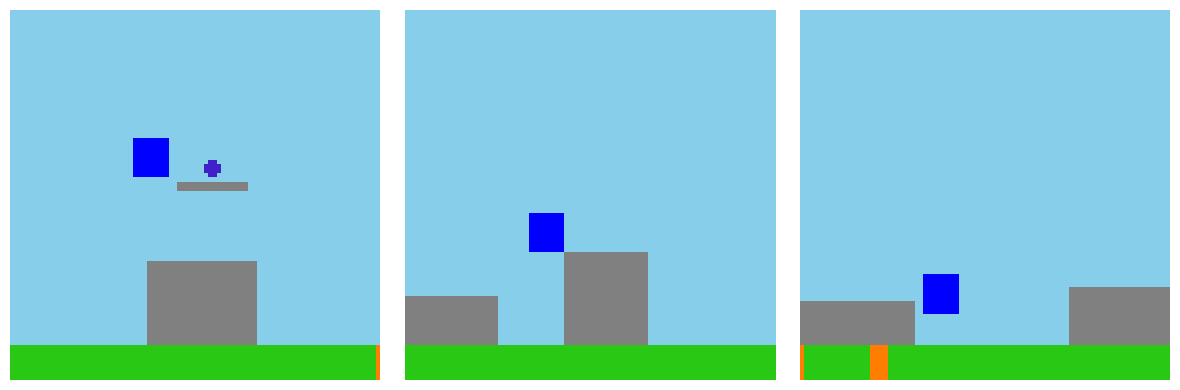

In [56]:
combine_concepts([CAVs['visible bullet'], CAVs['player dodging']], [-1, 1], True)

1*Visible lava + 1.5*Visible gold coin


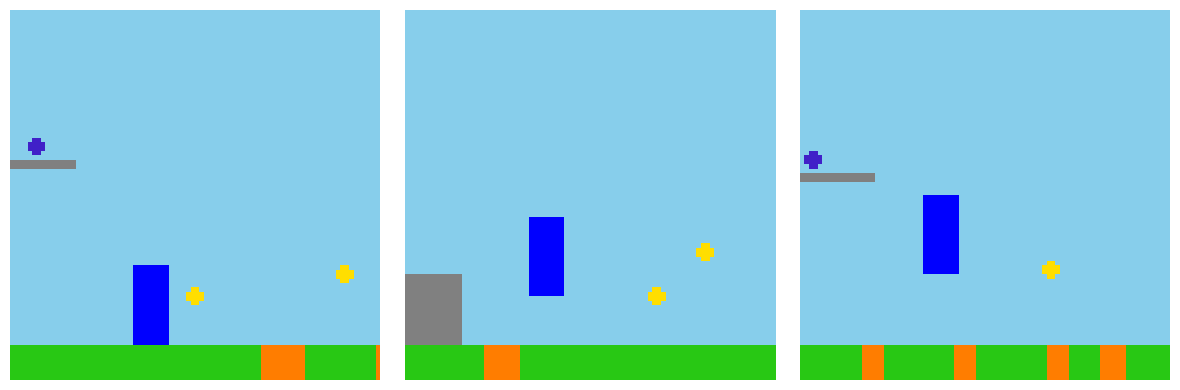

In [60]:
combine_concepts([CAVs['visible lava'], CAVs['visible gold coin']], [1, 1.5], True)

1.5*Event quantity - 1*Good event quantity


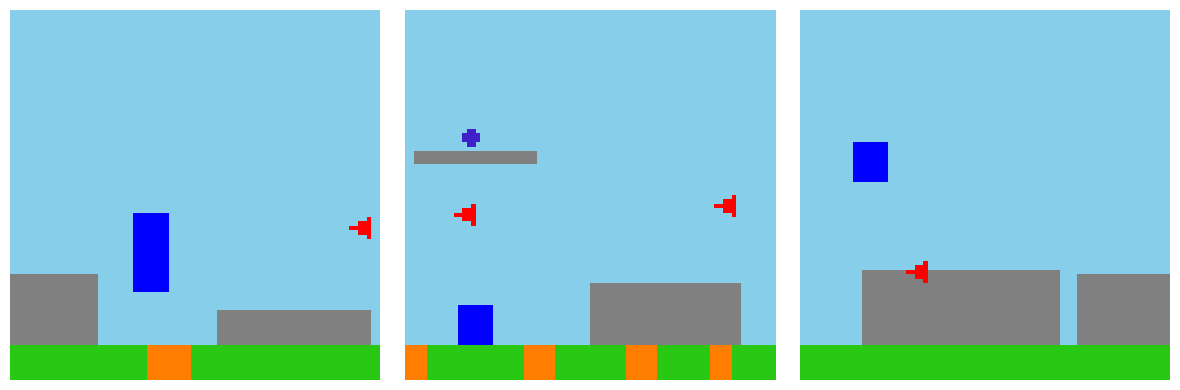

In [63]:
combine_concepts([CAVs['event quantity'], CAVs['good event quantity']], [1.5, -1], True)

1*Event quantity - 1*Bad event quantity


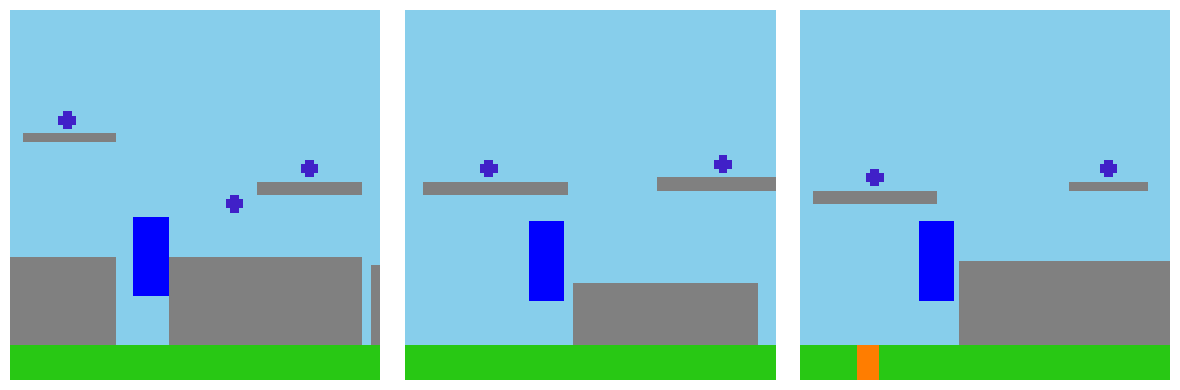

In [64]:
combine_concepts([CAVs['event quantity'], CAVs['bad event quantity']], [1, -1], True)

1*Visible blue coin - 1.5*Visible air wall


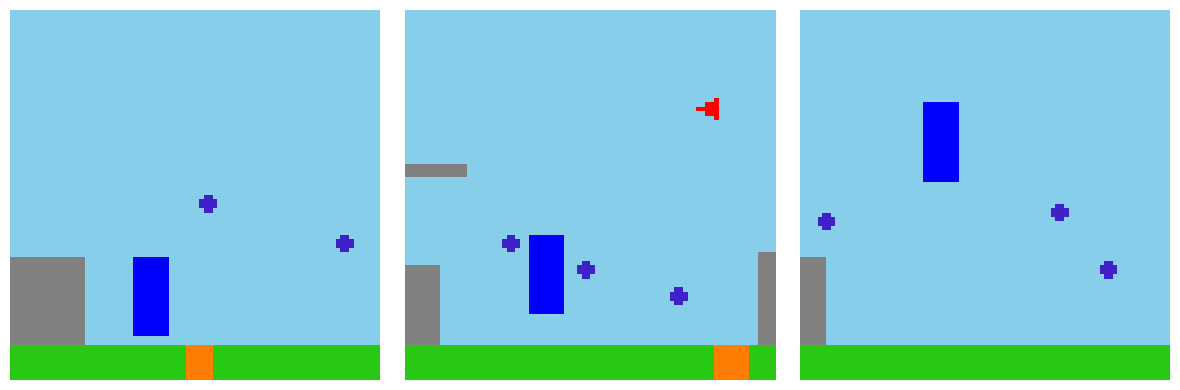

In [43]:
combine_concepts([CAVs['visible blue coin'], CAVs['visible air wall']], [1, -1.5], True)